<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/validate_trained_desi_complexdust_speculator_wavebins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/My Drive/speculator_fork


In [3]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from speculator import SpectrumPCA
from speculator import Speculator

In [4]:
# read DESI wavelength
wave = np.load('wave_fsps.npy')

In [5]:
wave_bin0 = (wave < 4500) 
wave_bin1 = (wave >= 4500) & (wave < 6500) 
wave_bin2 = (wave >= 6500) 
wave_bins = [wave_bin0, wave_bin1, wave_bin2]

In [8]:
n_param = 10
n_pcas  = [60, 30, 30]
N_trains = [int(5e6), int(5e6), int(5e6)]
architectures = ['3x256.', '', '']

(0.0, 1565.0)

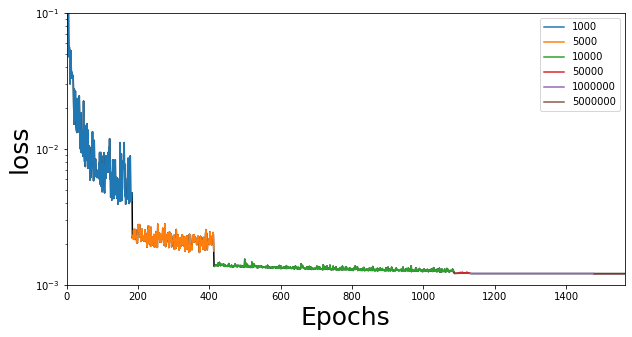

In [9]:
loss = np.loadtxt('DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.%sloss.dat' % (N_trains[0], 0, n_pcas[0], architectures[0]))

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(np.arange(loss.shape[0]), loss[:,2], c='k')

for batchsize in np.unique(loss[:,0]):
  isbatch = (loss[:,0] == batchsize)
  sub.plot(np.arange(loss.shape[0])[isbatch], loss[:,2][isbatch], label='%i' % batchsize)
sub.legend(loc='upper right')
sub.set_ylabel('loss', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-3, 0.1)
sub.set_xlabel('Epochs', fontsize=25)
sub.set_xlim(0, loss.shape[0])

In [10]:
speculators = [Speculator(restore=True, restore_filename='_DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.%slog' % (N_train, n_wave, n_pcas[n_wave], architectures[n_wave])) for n_wave, N_train in enumerate(N_trains)]

In [11]:
# read in training parameters and data
theta_test = np.load('DESI_complexdust.theta_test.npy')
_logspectrum_test = np.load('DESI_complexdust.logspectrum_fsps_test.npy')

logspectrum_test = []
for wave_bin in wave_bins: 
  logspectrum_test.append(_logspectrum_test[:,wave_bin])
logspectrum_test = np.concatenate(logspectrum_test, axis=1)
spectrum_test = 10**logspectrum_test

In [12]:
def combined_speculator(theta): 
  spectrum_spec = [] 
  for iwave in range(len(wave_bins)): 
    _logspectrum_spec = speculators[iwave].log_spectrum(theta)
    spectrum_spec.append(10**_logspectrum_spec)
  return np.concatenate(spectrum_spec, axis=1)

In [13]:
waves = []
for iwave in range(len(wave_bins)): 
  waves.append(wave[wave_bins[iwave]])
waves = np.concatenate(waves)

In [14]:
spectrum_spec = combined_speculator(theta_test.astype(np.float32))

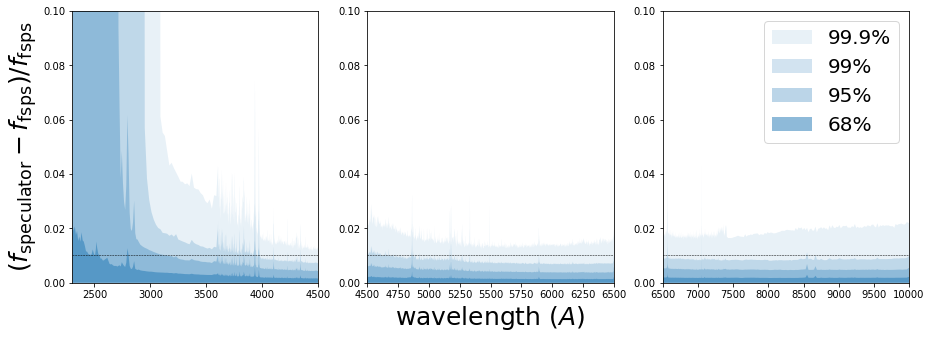

In [15]:
# more quantitative accuracy test of the Speculator model 
frac_dspectrum = np.abs((spectrum_spec - spectrum_test) / spectrum_test)
frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, [0.68, 0.95, 0.99, 0.999], axis=0)

fig = plt.figure(figsize=(15,5))
for iwave in range(len(wave_bins)): 
  sub = fig.add_subplot(1,3,iwave+1)
  sub.fill_between(waves, np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[3], fc='C0', ec='none', alpha=0.1, label='99.9%')
  sub.fill_between(waves, np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[2], fc='C0', ec='none', alpha=0.2, label='99%')
  sub.fill_between(waves, np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[1], fc='C0', ec='none', alpha=0.3, label='95%')
  sub.fill_between(waves, np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[0], fc='C0', ec='none', alpha=0.5, label='68%')
  sub.plot(waves, 0.01 * np.ones(len(waves)), c='k', ls='--', lw=0.5)
  if iwave == len(wave_bins) - 1: sub.legend(loc='upper right', fontsize=20)
  if iwave == 0: sub.set_xlim(2.3e3, 4.5e3)
  elif iwave == 1: 
    sub.set_xlabel('wavelength ($A$)', fontsize=25) 
    sub.set_xlim(4.5e3, 6.5e3)
  elif iwave == 2: sub.set_xlim(6.5e3, 1e4)
  if iwave == 0: sub.set_ylabel(r'$(f_{\rm speculator} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
  sub.set_ylim(0., 0.1)

2514


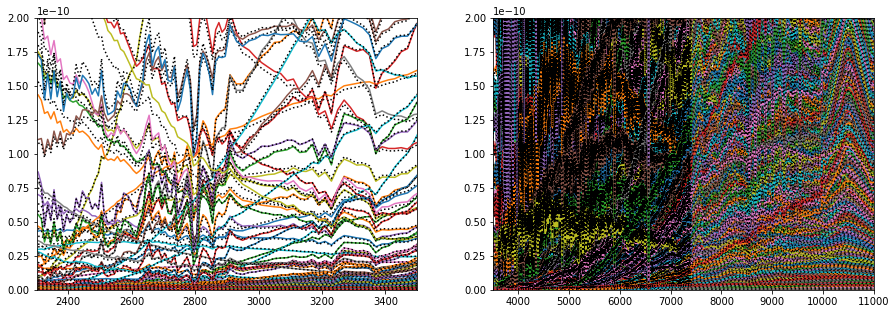

In [16]:
frac_dspectrum = np.abs((spectrum_spec - spectrum_test) / spectrum_test)
bad_NUV = (np.max(frac_dspectrum[:,waves < 3500], axis=1) > 0.05)
print(np.sum(bad_NUV))

fig = plt.figure(figsize=(15,5))
for i in range(2): 
  sub = fig.add_subplot(1,2,i+1)

  for ii in np.arange(spectrum_test.shape[0])[bad_NUV]: 
    sub.plot(waves, spectrum_spec[ii])
    sub.plot(waves, spectrum_test[ii], c='k', ls=':')
  if i == 0: 
    sub.set_xlim(2.3e3, 3.5e3)
    sub.set_ylim(0., 2e-10)
  elif i == 1: 
    sub.set_xlim(3.5e3, 1.1e4)
    sub.set_ylim(0., 2e-10)

8835 spectra have almost no UV


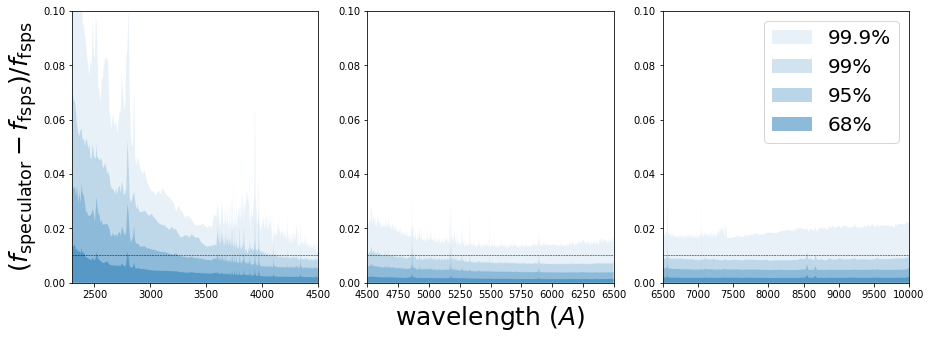

In [17]:
noUV = (np.median(spectrum_test[:,waves < 3500], axis=1) < 1e-11)
print('%i spectra have almost no UV' % np.sum(noUV))

fig = plt.figure(figsize=(15,5))
for iwave in range(len(wave_bins)): 
  # more quantitative accuracy test of the Speculator model 
  if iwave == 0: 
    frac_dspectrum = np.abs((spectrum_spec[~noUV,:][:,wave_bins[iwave]] - spectrum_test[~noUV,:][:,wave_bins[iwave]]) / spectrum_test[~noUV,:][:,wave_bins[iwave]])
    frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, [0.68, 0.95, 0.99, 0.999], axis=0)
  else: 
    frac_dspectrum = np.abs((spectrum_spec[:,wave_bins[iwave]] - spectrum_test[:,wave_bins[iwave]]) / spectrum_test[:,wave_bins[iwave]])
    frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, [0.68, 0.95, 0.99, 0.999], axis=0)

  sub = fig.add_subplot(1,3,iwave+1)
  sub.fill_between(waves[wave_bins[iwave]], np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[3], fc='C0', ec='none', alpha=0.1, label='99.9%')
  sub.fill_between(waves[wave_bins[iwave]], np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[2], fc='C0', ec='none', alpha=0.2, label='99%')
  sub.fill_between(waves[wave_bins[iwave]], np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[1], fc='C0', ec='none', alpha=0.3, label='95%')
  sub.fill_between(waves[wave_bins[iwave]], np.zeros(frac_dspectrum.shape[1]),
          frac_dspectrum_quantiles[0], fc='C0', ec='none', alpha=0.5, label='68%')
  sub.plot(waves, 0.01 * np.ones(len(waves)), c='k', ls='--', lw=0.5)
  if iwave == len(wave_bins) - 1: sub.legend(loc='upper right', fontsize=20)
  if iwave == 0: sub.set_xlim(2.3e3, 4.5e3)
  elif iwave == 1: 
    sub.set_xlabel('wavelength ($A$)', fontsize=25) 
    sub.set_xlim(4.5e3, 6.5e3)
  elif iwave == 2: sub.set_xlim(6.5e3, 1e4)
  if iwave == 0: sub.set_ylabel(r'$(f_{\rm speculator} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
  sub.set_ylim(0., 0.1)

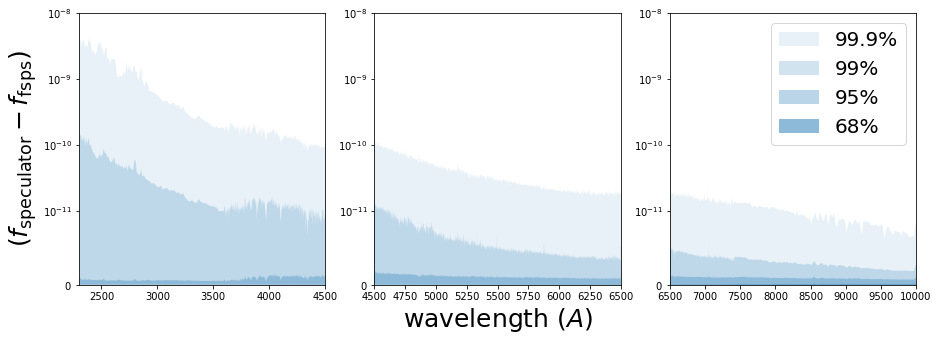

In [18]:
# more quantitative accuracy test of the Speculator model 
dspectrum = np.abs(spectrum_spec - spectrum_test)
dspectrum_quantiles = np.nanquantile(dspectrum, [0.68, 0.95, 0.99, 0.999], axis=0)

fig = plt.figure(figsize=(15,5))
for iwave in range(len(wave_bins)): 
  sub = fig.add_subplot(1,3,iwave+1)
  sub.fill_between(waves, np.zeros(dspectrum.shape[1]),
          dspectrum_quantiles[3], fc='C0', ec='none', alpha=0.1, label='99.9%')
  sub.fill_between(waves, np.zeros(dspectrum.shape[1]),
          dspectrum_quantiles[2], fc='C0', ec='none', alpha=0.2, label='99%')
  sub.fill_between(waves, np.zeros(dspectrum.shape[1]),
          dspectrum_quantiles[1], fc='C0', ec='none', alpha=0.3, label='95%')
  sub.fill_between(waves, np.zeros(dspectrum.shape[1]),
          dspectrum_quantiles[0], fc='C0', ec='none', alpha=0.5, label='68%')
  sub.plot(waves, 0.01 * np.ones(len(waves)), c='k', ls='--', lw=0.5)
  if iwave == len(wave_bins) - 1: sub.legend(loc='upper right', fontsize=20)
  if iwave == 0: sub.set_xlim(2.3e3, 4.5e3)
  elif iwave == 1: 
    sub.set_xlabel('wavelength ($A$)', fontsize=25) 
    sub.set_xlim(4.5e3, 6.5e3)
  elif iwave == 2: sub.set_xlim(6.5e3, 1e4)
  if iwave == 0: sub.set_ylabel(r'$(f_{\rm speculator} - f_{\rm fsps})$', fontsize=25) 
  sub.set_yscale('symlog', linthreshy=1e-11)
  sub.set_ylim(0., 1e-8)

(0.0, 1.0)

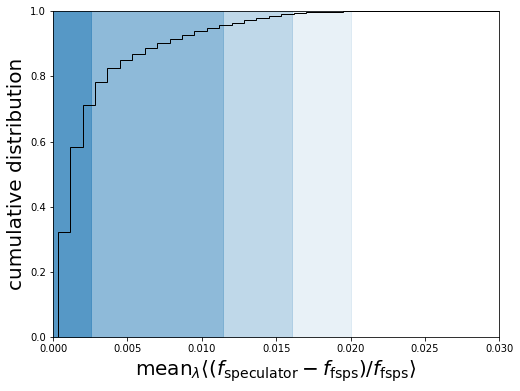

In [19]:
mean_frac_dspectrum = np.mean(np.abs((spectrum_spec - spectrum_test) / spectrum_test), axis=1)
quant = np.quantile(mean_frac_dspectrum, [0.68, 0.95, 0.99, 0.999])
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for q, a in zip(quant[::-1], [0.1, 0.2, 0.3, 0.5]): 
  sub.fill_between([0., q], [0., 0.], [1., 1.], alpha=a, color='C0')
_ = sub.hist(mean_frac_dspectrum, 40, density=True, histtype='step', cumulative=True, color='k')
sub.set_xlabel(r'${\rm mean}_\lambda \langle (f_{\rm speculator}  - f_{\rm fsps}) / f_{\rm fsps} \rangle$', fontsize=20)
sub.set_xlim(0., 0.03)
sub.set_ylabel('cumulative distribution', fontsize=20)
sub.set_ylim(0., 1.)

(0.0, 1.0)

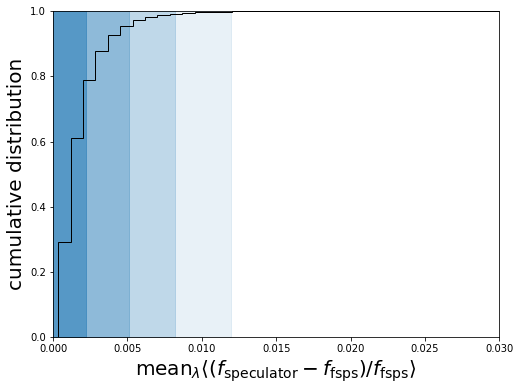

In [21]:
mean_frac_dspectrum = np.mean(np.abs((spectrum_spec[~noUV] - spectrum_test[~noUV]) / spectrum_test[~noUV]), axis=1)
quant = np.quantile(mean_frac_dspectrum, [0.68, 0.95, 0.99, 0.999])
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for q, a in zip(quant[::-1], [0.1, 0.2, 0.3, 0.5]): 
  sub.fill_between([0., q], [0., 0.], [1., 1.], alpha=a, color='C0')
_ = sub.hist(mean_frac_dspectrum, 40, density=True, histtype='step', cumulative=True, color='k')
sub.set_xlabel(r'${\rm mean}_\lambda \langle (f_{\rm speculator}  - f_{\rm fsps}) / f_{\rm fsps} \rangle$', fontsize=20)
sub.set_xlim(0., 0.03)
sub.set_ylabel('cumulative distribution', fontsize=20)
sub.set_ylim(0., 1.)